# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sklearn
import matplotlib.pyplot as plt

/home/lia/Desktop/HES/Semestre_5/ML/w4-isc-ml-Eteroclia/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch the data


We fetch the dataset using it's id (186)

In [2]:
from ucimlrepo import list_available_datasets,fetch_ucirepo

# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  


We check the dataset to see what it contains.

In [3]:
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

We split the set into a X (the features) and y (the wanted values)

In [4]:
# data (as pandas dataframes) 

y = wine_quality.data.targets 
o = wine_quality.data.original

In [5]:
X=o.drop("quality", axis=1)

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [6]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
dtypes: float64(11), object(1)
memory usage: 609.2+ KB


In [8]:
print(f'number of white wine: {X[X["color"]=="white"]["color"].count()}')

number of white wine: 4898


## Data Exploration

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

Split the set between white and red.

In [9]:
X_white=X[X["color"]=="white"].drop("color",axis=1)
X_white.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [10]:
X_red=X[X["color"]=="red"].drop("color",axis=1)
X_red.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


We plot each feature in a set white/red to compare their values. 

<Axes: xlabel='color', ylabel='alcohol'>

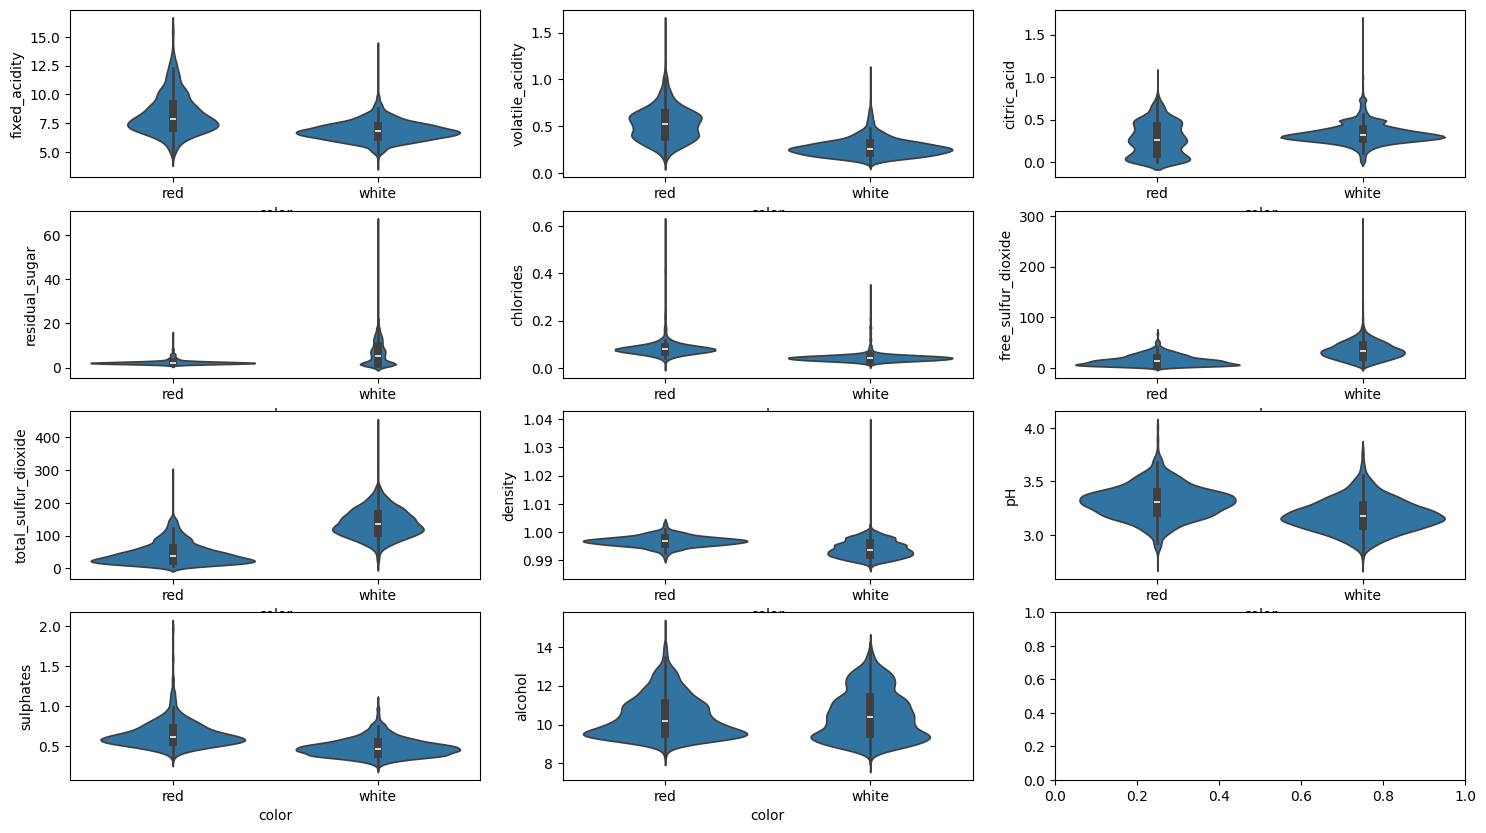

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))
# Create the violin plot
sns.violinplot(ax=axes[0, 0],x='color', y='fixed_acidity', data=X)
sns.violinplot(ax=axes[0, 1],x='color', y='volatile_acidity', data=X)
sns.violinplot(ax=axes[0, 2],x='color', y='citric_acid', data=X)
sns.violinplot(ax=axes[1, 0],x='color', y='residual_sugar', data=X)
sns.violinplot(ax=axes[1, 1],x='color', y='chlorides', data=X)
sns.violinplot(ax=axes[1, 2],x='color', y='free_sulfur_dioxide', data=X)
sns.violinplot(ax=axes[2, 0],x='color', y='total_sulfur_dioxide', data=X)
sns.violinplot(ax=axes[2, 1],x='color', y='density', data=X)
sns.violinplot(ax=axes[2, 2],x='color', y='pH', data=X)
sns.violinplot(ax=axes[3, 0],x='color', y='sulphates', data=X)
sns.violinplot(ax=axes[3, 1],x='color', y='alcohol', data=X)


# Display the plot
#plt.show()

We can see where the values are similar and where they aren't. For exemple acidity is different but ph is fairly similar.

It also mean that we should be able to separate the color of a wine based on chemical properties.

We will then plot the correlation between all these features to see if some should/could be removed.

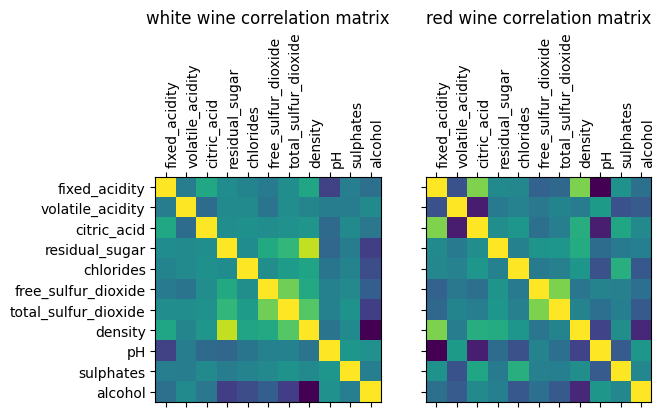

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)


ax[0].matshow(X[X["color"]=="white"].drop("color",axis=1).corr(method='pearson'))

ax[0].set_xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=90,ha="left")
ax[0].set_yticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11))
ax[0].set_title("white wine correlation matrix")


ax[1].matshow(X[X["color"]=="red"].drop("color",axis=1).corr(method='pearson'))
ax[1].set_xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=90,ha="left")
ax[1].set_yticks(labels=list(),ticks=range(0,11))
ax[1].set_title("red wine correlation matrix")

plt.show()


There is no correlation that is high enough to be worth removing features.

## Data Exploration using Unsupervised Learning

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

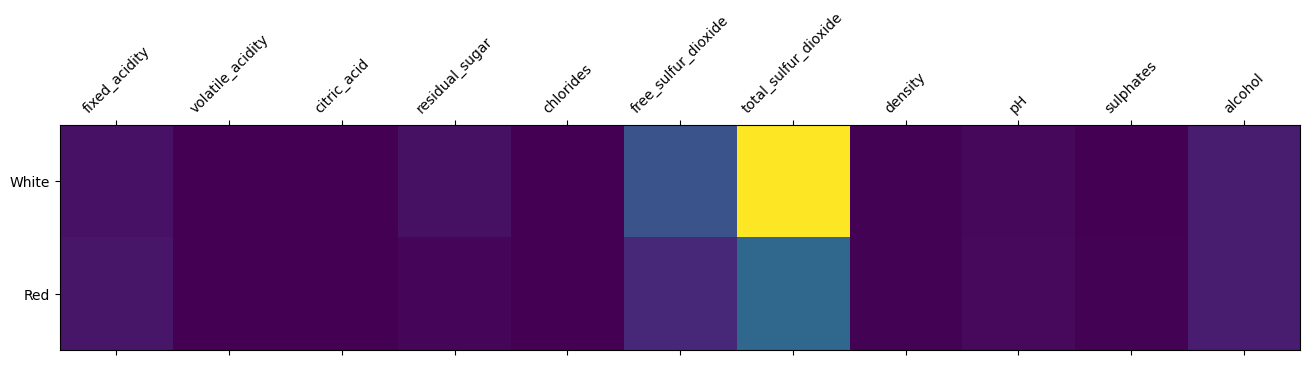

In [73]:
X_red_mean=X_red.mean()
X_white_mean=X_white.mean()
res=pd.DataFrame({"white":X_white_mean,"Red":X_red_mean})
plt.matshow(res.transpose())
plt.xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=45)
plt.yticks(labels=["White","Red"],ticks=[0,1])
plt.show()

While not foolproof, we can see that white wine has a higher average sulfur dioxide concentration, wich will help differentiate the colors.

In [14]:
from sklearn.preprocessing import RobustScaler


### Using PCA to reduce the dimensionality

We scale the data on the whole (combined) set before going further.

In [15]:
scaler=RobustScaler()
labels=X["color"]
rescaled_X=pd.DataFrame(scaler.fit_transform(X.drop("color",axis=1)),columns=list(X)[:-1])
rescaled_X=rescaled_X.join(labels)
rescaled_X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color
0,0.307692,2.411765,-2.214286,-0.174603,1.074074,-0.750000,-1.063291,0.625806,1.428571,0.294118,-0.500000,red
1,0.615385,3.470588,-2.214286,-0.063492,1.888889,-0.166667,-0.645570,0.410753,-0.047619,1.000000,-0.277778,red
2,0.615385,2.764706,-1.928571,-0.111111,1.666667,-0.583333,-0.810127,0.453763,0.238095,0.823529,-0.277778,red
3,3.230769,-0.058824,1.785714,-0.174603,1.037037,-0.500000,-0.734177,0.668817,-0.238095,0.411765,-0.277778,red
4,0.307692,2.411765,-2.214286,-0.174603,1.074074,-0.750000,-1.063291,0.625806,1.428571,0.294118,-0.500000,red
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.615385,-0.470588,-0.142857,-0.222222,-0.296296,-0.208333,-0.329114,-0.806452,0.285714,-0.058824,0.500000,white
6493,-0.307692,0.176471,0.357143,0.793651,0.000000,1.166667,0.632911,0.002151,-0.285714,-0.294118,-0.388889,white
6494,-0.384615,-0.294118,-0.857143,-0.285714,-0.222222,0.041667,-0.088608,-0.505376,-1.047619,-0.294118,-0.500000,white
6495,-1.153846,0.000000,-0.071429,-0.301587,-0.925926,-0.375000,-0.101266,-1.333333,0.619048,-0.764706,1.388889,white


In [16]:
import plotly.express as px
from sklearn.decomposition import PCA

We plot multiple PCA set to see different possiblities.

In [17]:

pca = PCA()
components = pca.fit_transform(rescaled_X[list(rescaled_X)[:-1]])
labels = {
    str(i): f'PC {i+1} ({var:.1f}%)'
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=rescaled_X["color"],
)
fig.update_traces(diagonal_visible=False)
fig.show()

We can see how good the separation is for each PCA.

We will now run a normal PCA wich will find the best separation possible.

In [18]:


pca = PCA(n_components=2)
components = pca.fit_transform(rescaled_X[list(rescaled_X)[:-1]])

fig = px.scatter(components, x=0, y=1, color=rescaled_X['color'])
fig.show()

Here we can see that we do indeed have a pretty good separation between red and white wine.

### Cluster the data in 2-dimensional space



We will now use a kmean clustering algorithme as a first algorithme to see how good a separation it can obtain.

In [19]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate

In [20]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(components)
centers=kmeans.cluster_centers_

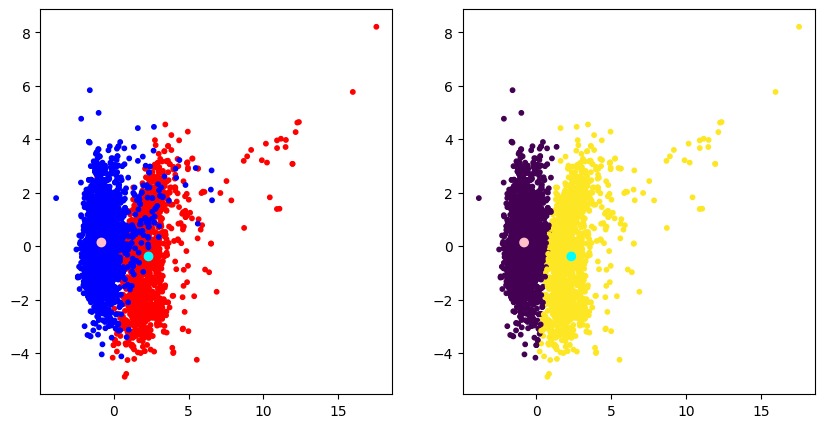

In [21]:
colors=list(map(lambda x : "Blue" if x=="white" else "Red",X["color"]))
figs, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(components[:,0],components[:,1],c=colors,s=10)
ax[0].scatter(centers[:,0],centers[:,1],c=["Pink","Cyan"])

ax[1].scatter(components[:,0],components[:,1],c=kmeans.predict(components),s=10)
ax[1].scatter(centers[:,0],centers[:,1],c=["Pink","Cyan"])
plt.show()


We can see the PCA on the left with the centers of the clusters in pink and cyan, and the kmeans result on the right. We can see some misclasification, but we will calculate multiple scores to be sure.

In [22]:
from sklearn.utils import shuffle

In [23]:
shuffled_X=shuffle(rescaled_X).reset_index(drop=True)
scores=cross_validate(kmeans, shuffled_X.drop("color",axis=1),shuffled_X["color"].map(lambda x: 1 if x=="red" else 0) , cv=10,scoring=["accuracy","f1_weighted","adjusted_mutual_info_score"])

print(scores["test_accuracy"])
print(scores["test_f1_weighted"])
print(scores["test_adjusted_mutual_info_score"])

[0.98307692 0.02615385 0.96615385 0.96461538 0.98153846 0.96153846
 0.98153846 0.03235747 0.97072419 0.97072419]
[0.98323969 0.02808314 0.96640322 0.96506324 0.98171928 0.96203575
 0.98157692 0.04039588 0.97104948 0.97098808]
[0.86162831 0.80245843 0.75570656 0.76122326 0.8556817  0.7311069
 0.84084948 0.76402804 0.76696084 0.76152945]


The results can vary from very good to abysmall, due to the shuffling of the set. However, the result are globally good.

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

We begin by splitting the set in two, train and test.

In [74]:
train_set, test_set = train_test_split(shuffled_X)


We then train the model on the training set, it being a logistic regression model.

In [75]:
reg=LogisticRegression()
gridValues={'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_search = GridSearchCV(
                           estimator = reg,
                           param_grid = gridValues,
                           scoring = 'f1',
                           cv = 5,
                           )
grid_search.fit(test_set.drop("color",axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [76]:
print("train values:")
print(f'best c is {grid_search.best_estimator_}')
print(f'best score is {grid_search.best_score_}')

train values:
best c is LogisticRegression(C=100)
best score is 0.9908324733402132


We can see the F1 score obtained by this model on the training set here.

We will now try this model with the testing data.

In [77]:
predic_y=grid_search.best_estimator_.predict(test_set.drop("color",axis=1))

In [29]:
from sklearn.model_selection import LearningCurveDisplay

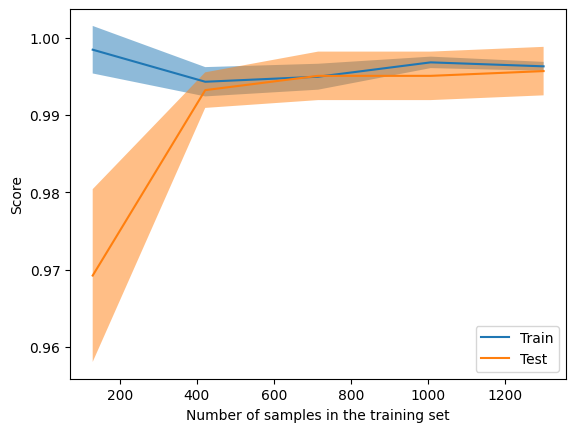

In [81]:
LearningCurveDisplay.from_estimator(grid_search.best_estimator_,test_set.drop("color",axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))
plt.show()

The model appears to not be suffering from overfitting, albeit not much. The result is still very good.

We will plot a confusion matrix to see the error that where made as well as compute the different scores once again.

In [31]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,ConfusionMatrixDisplay


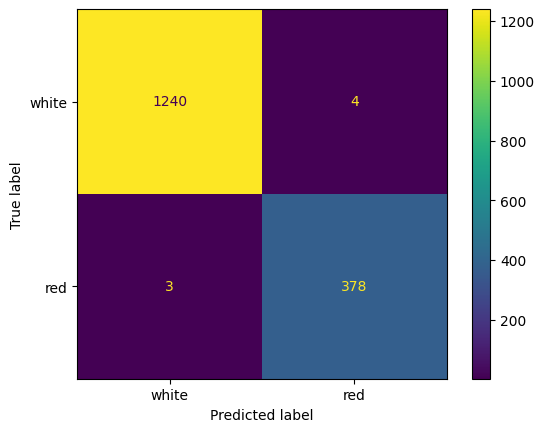

f1:0.9908256880733946
accuracy:0.9956923076923077


In [82]:
conf_mat=confusion_matrix(predic_y,test_set["color"].map(lambda x: 1 if x=="red" else 0))
ConfusionMatrixDisplay(conf_mat,display_labels=["white","red"]).plot()
plt.show()
print(f'f1:{f1_score(predic_y,test_set["color"].map(lambda x: 1 if x=="red" else 0))}')
print(f'accuracy:{accuracy_score(predic_y,test_set["color"].map(lambda x: 1 if x=="red" else 0))}')

Considering the best scores are in the (very) high 90's, we can consider the model performances as good.

### Basic model interpretability: inspecting the model

We will then check the feature importance, that is wich feature is/are important(s) for the classifcation and wich aren't. 

In [33]:
coefs=list(zip(list(X.drop("color",axis=1)),(grid_search.best_estimator_.coef_.flatten())))
#sns.swarmplot(data=coefs, x="importance", y="feature")
print(coefs)


[('fixed_acidity', np.float64(0.20517423666668272)), ('volatile_acidity', np.float64(1.2375096818107851)), ('citric_acid', np.float64(-0.36562558591476374)), ('residual_sugar', np.float64(-5.033383921140923)), ('chlorides', np.float64(0.6220580580388668)), ('free_sulfur_dioxide', np.float64(1.6905244053839126)), ('total_sulfur_dioxide', np.float64(-4.369627722505803)), ('density', np.float64(6.234778650684632)), ('pH', np.float64(0.3068741308408787)), ('sulphates', np.float64(0.7400521737230683)), ('alcohol', np.float64(2.3181775460931333))]


Positive component indicate an impact in a direction, negative in the other. The scores themselves are subject to change depending on dataset shuffling.

### Removing features to test their importance

We will now remove the most important feature (density in this case) to see what happens to the classification score. 

In [83]:
reg2=LogisticRegression()
gridValues={'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_search_2 = GridSearchCV(
                           estimator = reg2,
                           param_grid = gridValues,
                           scoring = 'f1',
                           cv = 5,
                           )
grid_search_2.fit(test_set.drop(["color","density"],axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [84]:
print("train values:")
print(f'best c is {grid_search.best_estimator_}')
print(f'best score is {grid_search.best_score_}')

train values:
best c is LogisticRegression(C=100)
best score is 0.9908324733402132


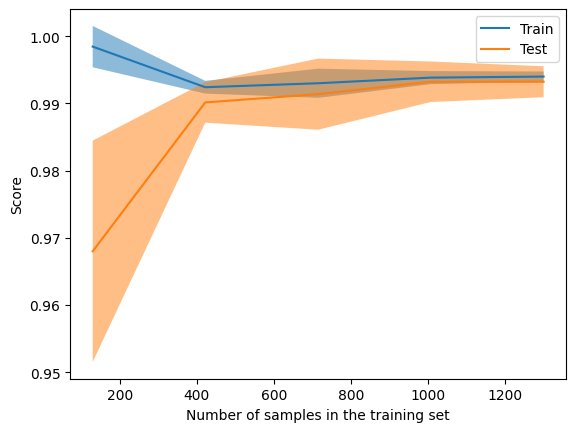

In [87]:
predic_y_2=grid_search_2.best_estimator_.predict(test_set.drop(["color","density"],axis=1))
LearningCurveDisplay.from_estimator(grid_search_2.best_estimator_,test_set.drop(["color","density"],axis=1),test_set["color"].map(lambda x: 1 if x=="red" else 0))
plt.show()

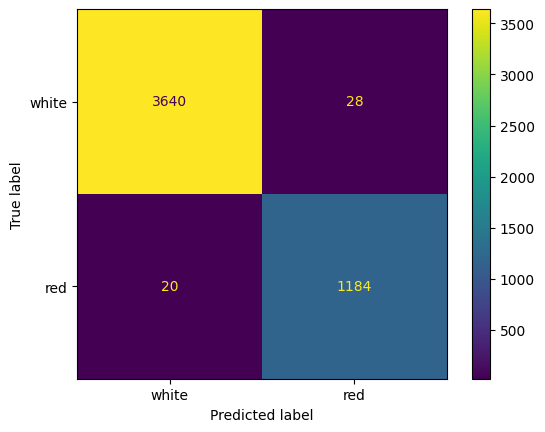

f1:0.9801324503311258
accuracy:0.9901477832512315


In [37]:
conf_mat_2=confusion_matrix(predic_y_2,test_set["color"].map(lambda x: 1 if x=="red" else 0))
ConfusionMatrixDisplay(conf_mat_2,display_labels=["white","red"]).plot()
plt.show()
print(f'f1:{f1_score(predic_y_2,test_set["color"].map(lambda x: 1 if x=="red" else 0))}')
print(f'accuracy:{accuracy_score(predic_y_2,test_set["color"].map(lambda x: 1 if x=="red" else 0))}')

The f1 score is slightly lower, but the score is so high still we can consider the removal of the feature irrelevant.

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.


In [38]:
#sns.swarmplot(data=rescaled_X,x="color")
import shap
import xgboost


In [39]:
model = xgboost.XGBClassifier().fit(X.drop("color",axis=1),X["color"].map(lambda x: 1 if x=="red" else 0))

explainer=shap.Explainer(model,X.drop("color",axis=1))
shap_values=explainer(X.drop("color",axis=1))

 98%|===================| 6345/6497 [00:13<00:00]        

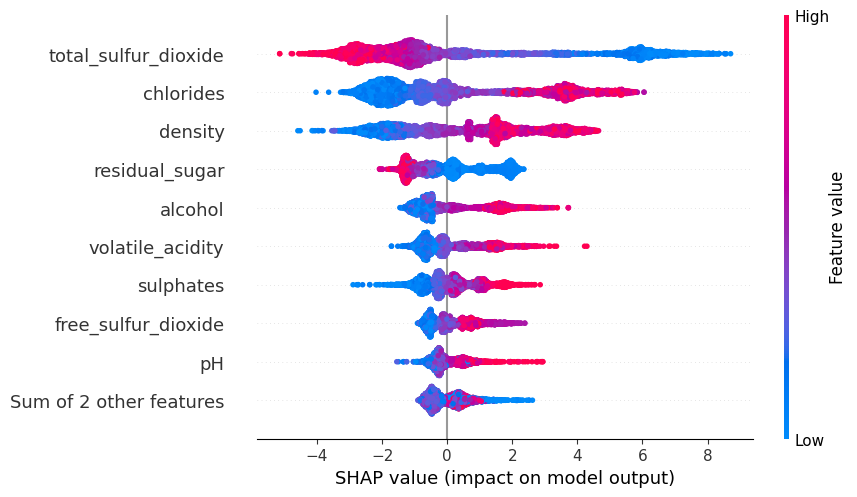

In [40]:
shap.plots.beeswarm(shap_values)

We can see here the importance of each feature depending of their value. 

We can the use a partial dependence plot to see the impact of the value of a specific feature.

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 200130). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship.

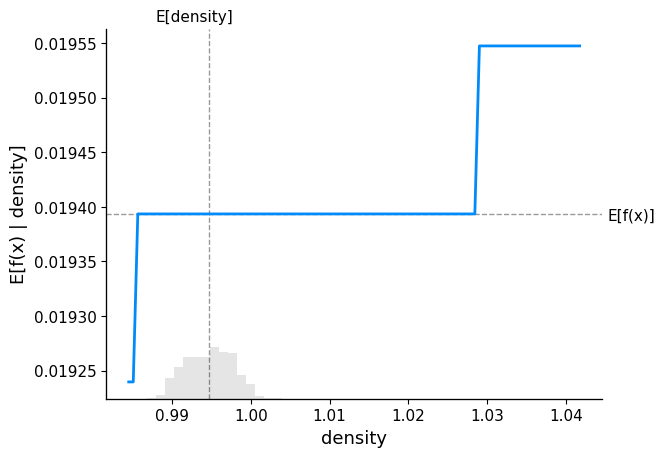

In [88]:

shap.partial_dependence_plot(
    "density",
    grid_search.best_estimator_.predict,
    X.drop("color",axis=1),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Here we can see the impact of density. The higher it is, the more impact on the classification.

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

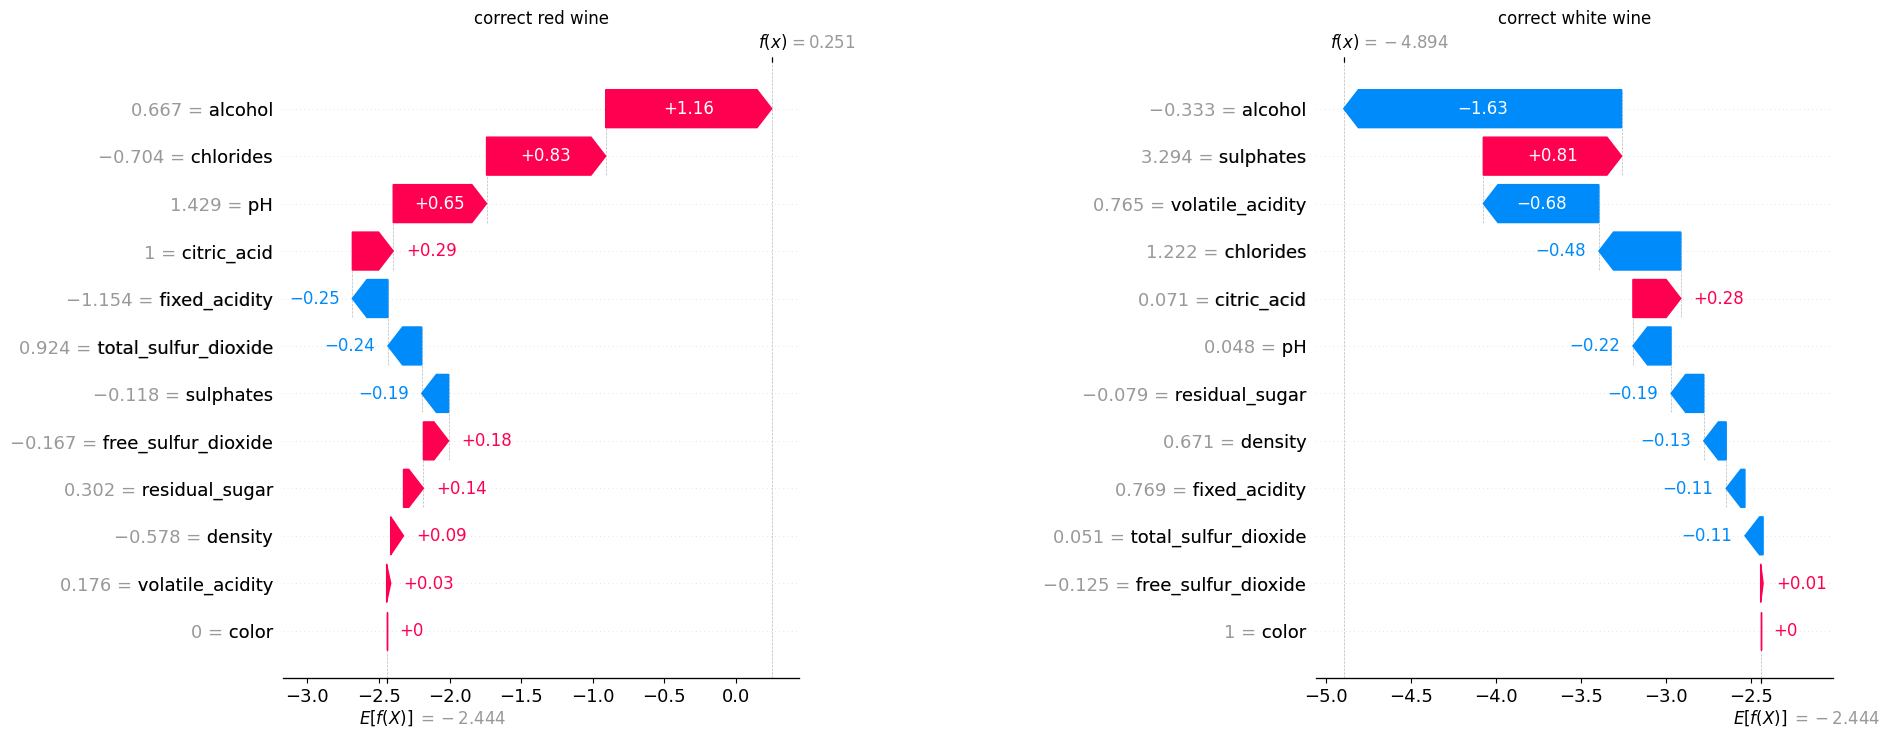

In [91]:
"""shap.plots.waterfall(shap_values[0], max_display=20,show=False)
plt.title("correct red wine")
plt.show()
shap.plots.waterfall(shap_values[5000], max_display=20,show=False)
plt.title("correct white wine")
plt.show()"""

figs, ax = plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
shap.plots.waterfall(shap_values[0], max_display=20,show=False)
ax[0].set_title("correct red wine")
plt.sca(ax[1])
shap.plots.waterfall(shap_values[4000], max_display=20,show=False)
ax[1].set_title("correct white wine")
plt.subplots_adjust(wspace=1)
figs.set_size_inches(20, 8)
plt.show()


Here we can compare the impact of each features between a correctly classified red and white wine.

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

In [43]:
error=[]
Y_color=list(test_set["color"].map(lambda x: 1 if x=="red" else 0))

for idx,res in enumerate(predic_y):
    if res!=Y_color[idx]:
        #print(res,Y_color[idx])
        error.append((idx,"red" if Y_color[idx] else "white"))
print(error)
print(len(error))

[(238, 'white'), (342, 'red'), (402, 'white'), (460, 'red'), (681, 'white'), (841, 'red'), (1077, 'white'), (1472, 'white'), (1718, 'white'), (1776, 'red'), (1783, 'red'), (1870, 'white'), (1879, 'white'), (2303, 'red'), (2326, 'white'), (2621, 'white'), (2868, 'red'), (2900, 'white'), (3165, 'white'), (3436, 'red'), (3451, 'white'), (3489, 'white'), (3843, 'red'), (4396, 'red'), (4461, 'red'), (4495, 'red')]
26


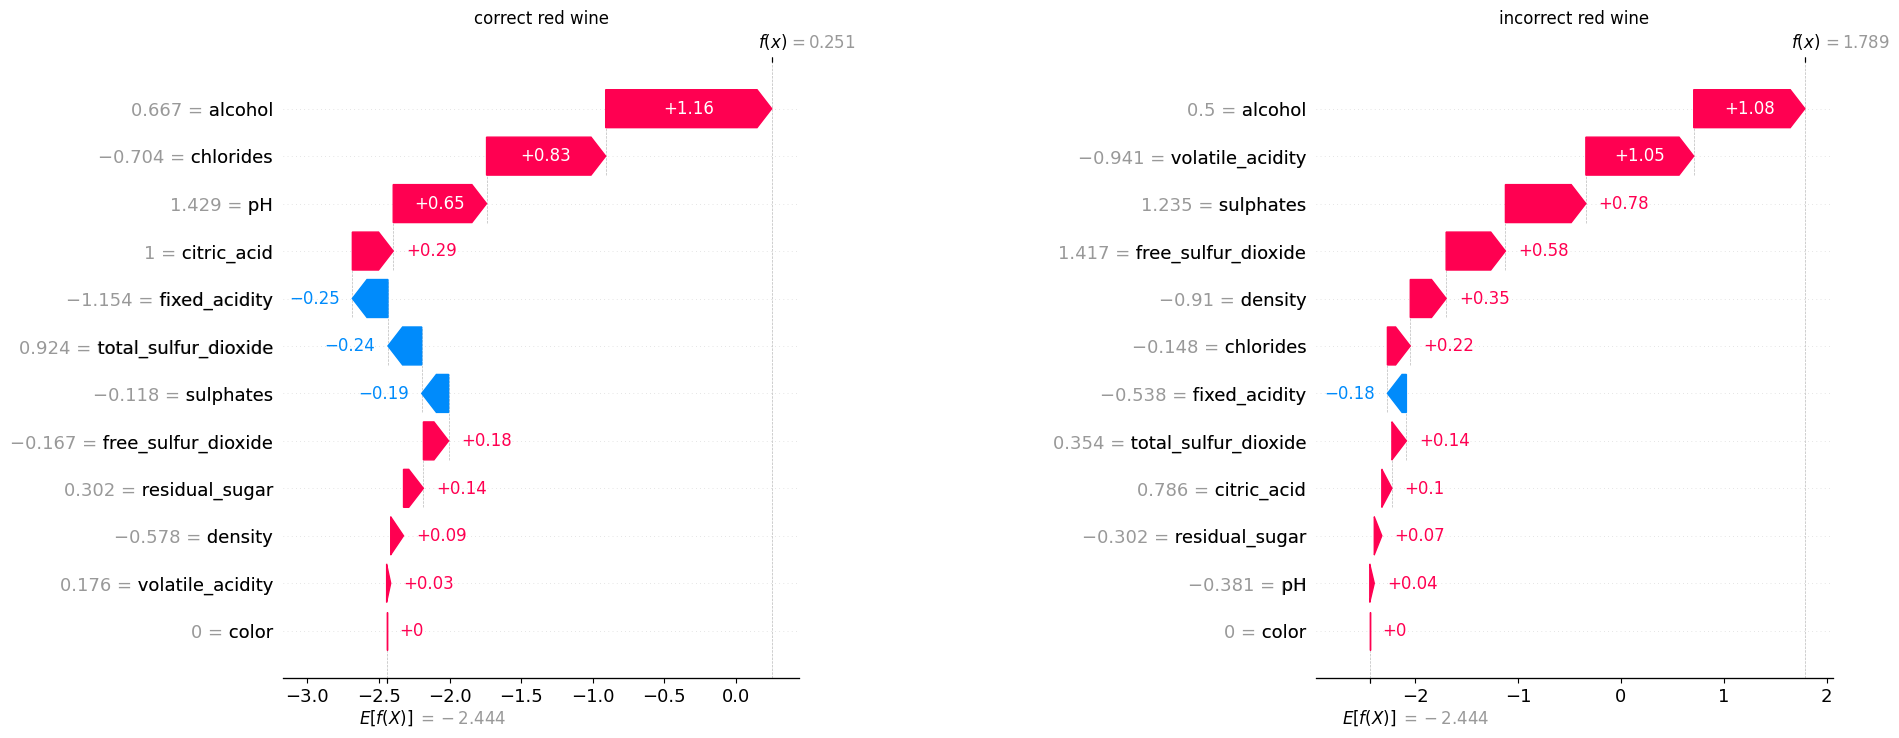

In [92]:
figs, ax = plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
shap.plots.waterfall(shap_values[0], max_display=20,show=False)
ax[0].set_title("correct red wine")
plt.sca(ax[1])
shap.plots.waterfall(shap_values[342], max_display=20,show=False)
ax[1].set_title("incorrect red wine")
plt.subplots_adjust(wspace=1)
figs.set_size_inches(20, 8)
plt.show()

We can see here what a correctly classified red wine looks like, and what an incorrectly classified one lokks like.

# Good vs Bad classification (3h)

We will now stop trying to find the color, and predict the quality of a wine, with those having a scrore superior to 6 being considered good.

In [45]:
binary_quality=y.map(lambda x : "good" if x>6 else "bad")
print(binary_quality)
X_resc_quality=rescaled_X.join(binary_quality)
print(X_resc_quality.head())

     quality
0        bad
1        bad
2        bad
3        bad
4        bad
...      ...
6492     bad
6493     bad
6494     bad
6495    good
6496     bad

[6497 rows x 1 columns]
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.307692          2.411765    -2.214286       -0.174603   1.074074   
1       0.615385          3.470588    -2.214286       -0.063492   1.888889   
2       0.615385          2.764706    -1.928571       -0.111111   1.666667   
3       3.230769         -0.058824     1.785714       -0.174603   1.037037   
4       0.307692          2.411765    -2.214286       -0.174603   1.074074   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -0.750000             -1.063291  0.625806  1.428571   0.294118   
1            -0.166667             -0.645570  0.410753 -0.047619   1.000000   
2            -0.583333             -0.810127  0.453763  0.238095   0.823529   
3            -0.500000            

In [46]:
list(X_resc_quality)

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'color',
 'quality']

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

In [47]:



red=X_resc_quality[X["color"]=="red"]
white=X_resc_quality[X["color"]=="white"]

print(f'number of bad white wine: {white[white["quality"]=="bad"]["quality"].count()} out of {white["quality"].count()}, or {white[white["quality"]=="bad"]["quality"].count()/white["quality"].count()*100}%')
print(f'number of bad red wine: {red[red["quality"]=="bad"]["quality"].count()} out of {red["quality"].count()}, or {red[red["quality"]=="bad"]["quality"].count()/red["quality"].count()*100}%')

number of bad white wine: 3838 out of 4898, or 78.35851367905268%
number of bad red wine: 1382 out of 1599, or 86.42901813633522%


We can see that non, there isn't an especially high correlation between color and quality, a good thing because this would be an enormous bias on the dataset.

We will now plot a heatmap of the mean feature value of good and bad wines.

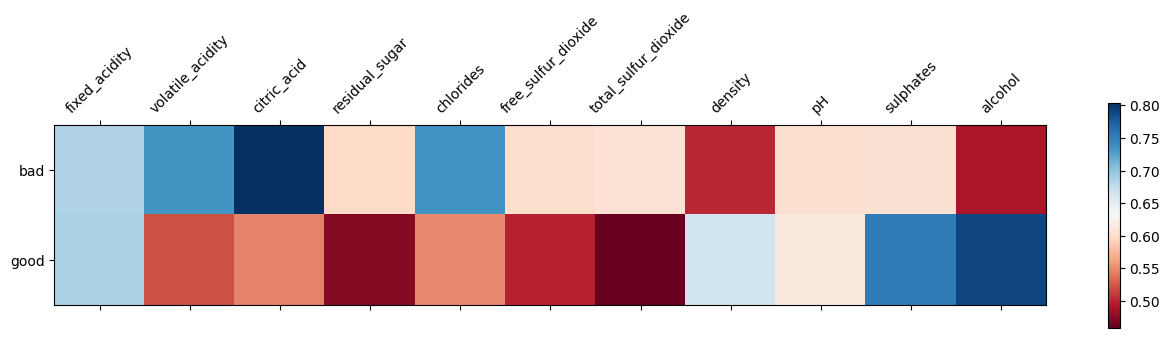

In [94]:
X_bad_mean=X_resc_quality[X_resc_quality["quality"]=="bad"].drop(["quality","color"],axis=1).abs().mean()
X_good_mean=X_resc_quality[X_resc_quality["quality"]=="good"].drop(["quality","color"],axis=1).abs().mean()
res2=pd.DataFrame({"bad":X_bad_mean,"good":X_good_mean})
plt.matshow(res2.transpose(),cmap="RdBu")
plt.xticks(labels=list(X.drop("color",axis=1)),ticks=range(0,11),rotation=45)
plt.yticks(labels=["bad","good"],ticks=[0,1])
plt.colorbar()
plt.show()

Some things we can see is that the alcohol content plays a huge role, for exemple.

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [49]:
from xgboost import XGBClassifier


In [50]:
train_set_2 , test_set_2= train_test_split(X_resc_quality)

In [51]:
gbc=XGBClassifier()
param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
transformed_df=train_set_2.drop(["quality","color"],axis=1).join(train_set_2["color"].map(lambda x: 1 if x=="red" else 0))
grid_search_3 = GridSearchCV(
                           estimator = gbc,
                           param_grid = param_grid,
                           scoring = 'f1',
                           cv = 5,
                           n_jobs=4,
                           )
grid_search_3.fit(transformed_df,train_set_2["quality"].map(lambda x: 1 if x=="good" else 0))

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.7, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3],
                         'n_estimators': [50, 100], 'subsample': [0.7, 0.9]},
             scoring='f1')

We will now check the results of the training of this model.

In [52]:
print("train values:")
print(f'best parameters are {grid_search_3.best_estimator_}')
print(f'best score (f1) is {grid_search_3.best_score_}')

train values:
best parameters are XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
best score (f1) is 0.5577051397737776


An f1 score of 55% is not good. We will see wether that is due to overfitting.

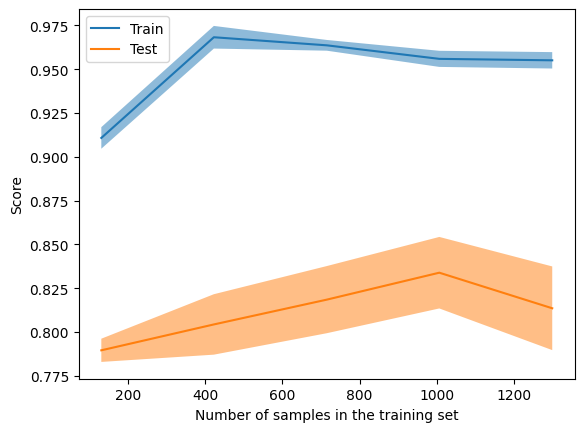

In [53]:
transformed_df_test=test_set_2.drop(["quality","color"],axis=1).join(test_set_2["color"].map(lambda x: 1 if x=="red" else 0))
predic_y_3=grid_search_3.best_estimator_.predict(transformed_df_test)
LearningCurveDisplay.from_estimator(grid_search_3.best_estimator_,transformed_df_test,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))
plt.show()

It appears the model overfit a bit but not catastrophicly so. The score (accuracy) is in a fairly good range compared to the f1 score.

We will plot the confusion matrix to see what it tells us.

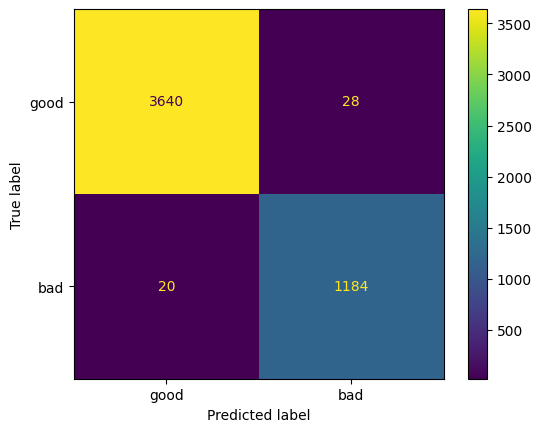

f1:0.5704099821746881
accuracy:0.8516923076923076


In [95]:
conf_mat_3=confusion_matrix(predic_y_3,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))
ConfusionMatrixDisplay(conf_mat_2,display_labels=["good","bad"]).plot()
plt.show()
print(f'f1:{f1_score(predic_y_3,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))}')
print(f'accuracy:{accuracy_score(predic_y_3,test_set_2["quality"].map(lambda x: 1 if x=="good" else 0))}')

The confusion matrix as well as the f1 and accuracy score on the test set do not seem to correspond, altough the scores are in line with the training's.

## Interpretability with SHAP

We will plot the feature importance of multiple wines to see if a correlation is apparrant.

In [55]:
explainer=shap.Explainer(grid_search_3.best_estimator_,transformed_df)
shap_values=explainer(transformed_df)

 99%|===================| 4821/4872 [00:14<00:00]        

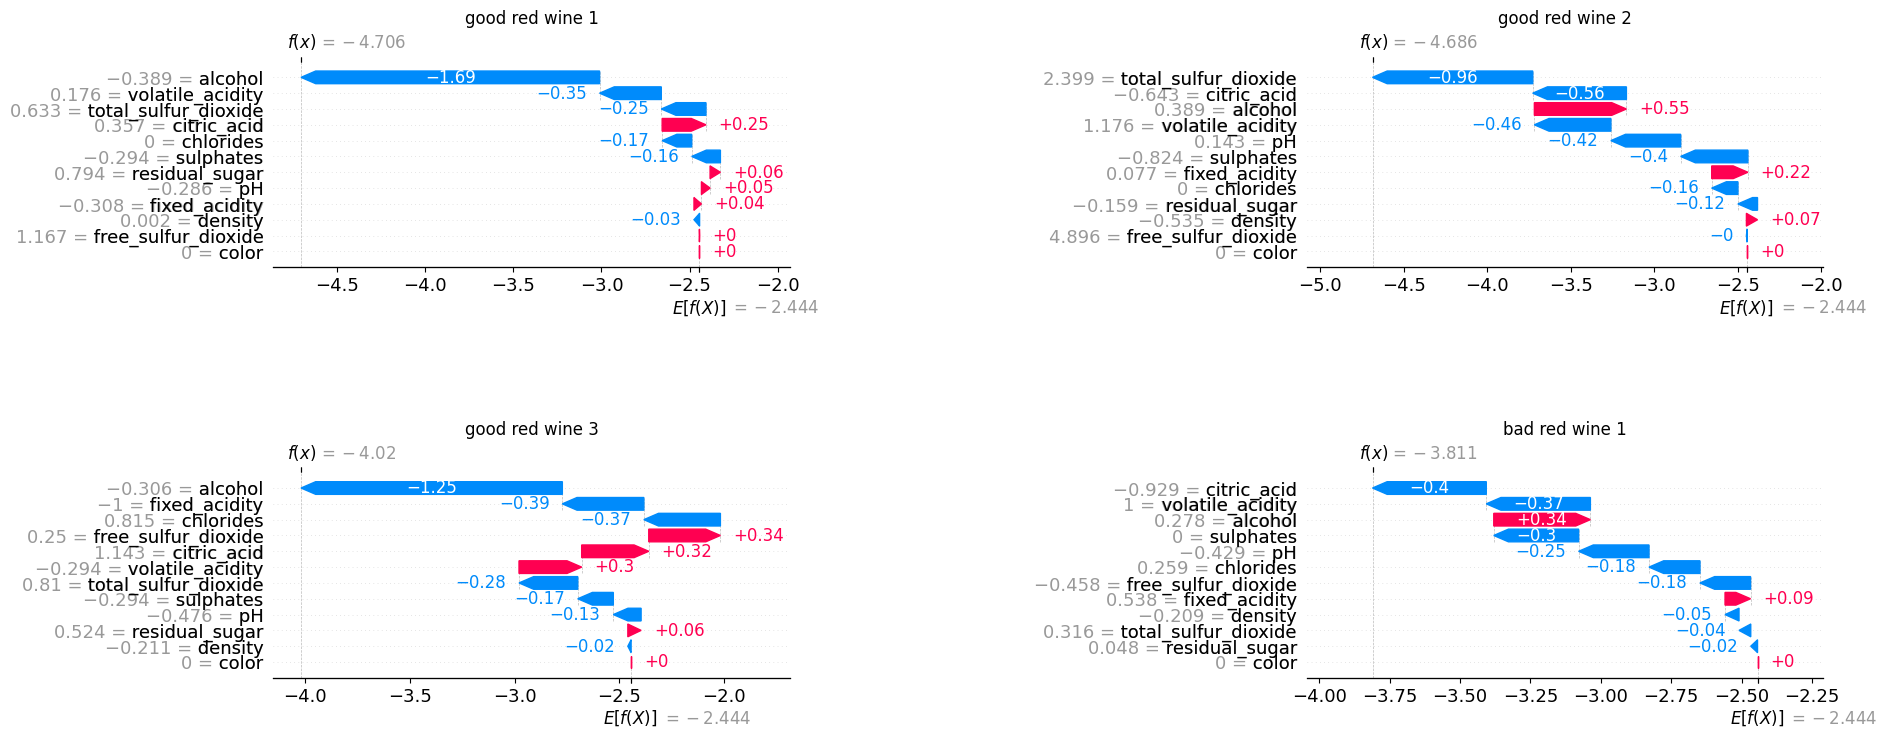

In [56]:
figs, ax = plt.subplots(2,2,figsize=(10,5))
plt.sca(ax[0][0])
shap.plots.waterfall(shap_values[7], max_display=20,show=False)
ax[0][0].set_title("good red wine 1")
plt.sca(ax[0][1])
shap.plots.waterfall(shap_values[8], max_display=20,show=False)
ax[0][1].set_title("good red wine 2")
plt.sca(ax[1][0])
shap.plots.waterfall(shap_values[16], max_display=20,show=False)
ax[1][0].set_title("good red wine 3")
plt.sca(ax[1][1])
shap.plots.waterfall(shap_values[9], max_display=20,show=False)
ax[1][1].set_title("bad red wine 1")
plt.subplots_adjust(wspace=1,hspace=1)
figs.set_size_inches(20, 8)
plt.show()

In [57]:


for idx,res in enumerate(X_resc_quality["quality"]):
    if res=="good":
        #print(res,Y_color[idx])
        print(f'{idx},{X_resc_quality.iloc[idx]["color"]}')


7,red
8,red
16,red
37,red
62,red
128,red
198,red
200,red
205,red
206,red
209,red
230,red
243,red
244,red
259,red
265,red
267,red
278,red
279,red
281,red
283,red
288,red
290,red
318,red
320,red
326,red
334,red
335,red
339,red
346,red
357,red
358,red
364,red
366,red
369,red
375,red
377,red
389,red
390,red
395,red
407,red
413,red
420,red
421,red
423,red
425,red
430,red
440,red
442,red
443,red
444,red
453,red
455,red
458,red
481,red
488,red
491,red
492,red
495,red
498,red
501,red
502,red
503,red
504,red
505,red
506,red
509,red
513,red
514,red
538,red
583,red
584,red
586,red
588,red
589,red
606,red
638,red
645,red
648,red
657,red
797,red
802,red
805,red
806,red
807,red
821,red
826,red
828,red
836,red
837,red
838,red
840,red
855,red
857,red
858,red
873,red
874,red
875,red
887,red
896,red
898,red
901,red
902,red
903,red
904,red
913,red
925,red
929,red
938,red
940,red
941,red
942,red
943,red
944,red
945,red
946,red
947,red
948,red
949,red
950,red
951,red
952,red
953,red
958,red
966,red
972,red

We will now compute the feature importance of the whole set using a tree explainer algorithme.

In [58]:
from shap import TreeExplainer

In [59]:
X_qual_encoded=X_resc_quality.drop(["quality","color"],axis=1).join(X_resc_quality["color"].map(lambda x: 1 if x=="red" else 0))

In [60]:
treeEx=TreeExplainer(grid_search_3.best_estimator_,transformed_df)
shap_vals=treeEx.shap_values(transformed_df_test)
print(shap_vals)


[[-0.13001664  1.15357634 -0.43148856 ... -0.28844376 -0.54611067
   0.        ]
 [-0.05411492 -0.37361694  0.01049886 ... -0.28342029 -0.32756629
   0.        ]
 [-0.49902472  1.00050191 -0.35434551 ... -0.36987783 -1.25837554
   0.        ]
 ...
 [ 0.07465057 -0.36554291 -0.18316501 ... -0.07869036  0.22763986
   0.        ]
 [ 0.15453541 -0.55301852 -0.57688019 ... -0.08898874 -1.23188121
   0.        ]
 [ 0.15373007 -0.09974648  0.10717064 ... -0.23716786  2.29860654
   0.        ]]


In [61]:
test_set_bad=test_set_2[test_set_2["quality"]=="bad"].drop(["color","quality"],axis=1).join(test_set_2["color"].map(lambda x: 1 if x=="red" else 0))
test_set_good=test_set_2[test_set_2["quality"]=="good"].drop(["color","quality"],axis=1).join(test_set_2["color"].map(lambda x: 1 if x=="red" else 0))
shap_vals_bad=treeEx.shap_values(test_set_bad)
shap_vals_good=treeEx.shap_values(test_set_good)


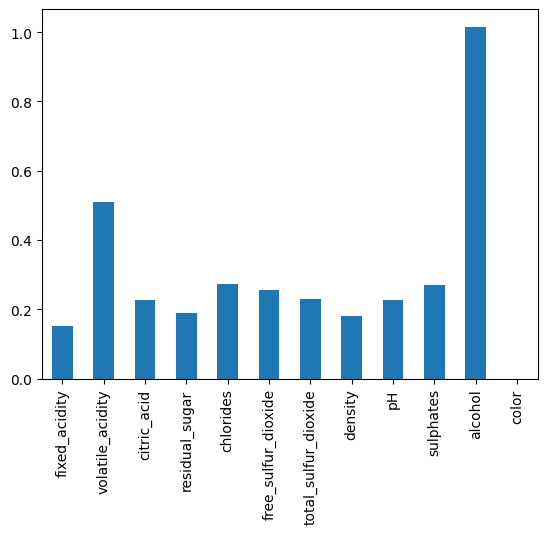

In [62]:
shap_vals_df=pd.DataFrame(shap_vals,columns=list(transformed_df_test))
shap_vals_df_mav=shap_vals_df.abs().mean()
shap_vals_df_mav.plot.bar()
plt.show()

We can see clearly which feature are important or not for the whole set. As observed befor, color is irrelevant.

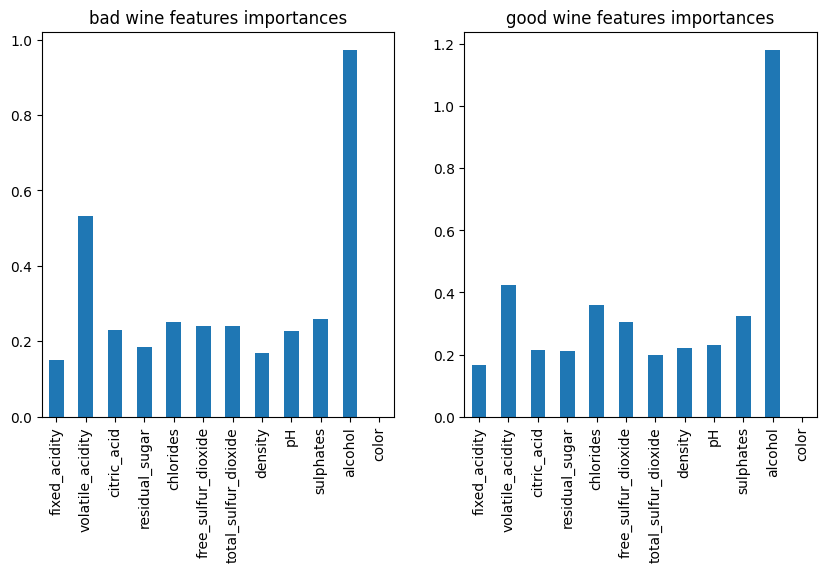

In [63]:
figs, ax = plt.subplots(1,2,figsize=(10,5))
shap_vals_df=pd.DataFrame(shap_vals_bad,columns=list(transformed_df_test))
shap_vals_df_mav=shap_vals_df.abs().mean()
plt.sca(ax[0])
shap_vals_df_mav.plot.bar()
ax[0].set_title("bad wine features importances")
shap_vals_df=pd.DataFrame(shap_vals_good,columns=list(transformed_df_test))
shap_vals_df_mav=shap_vals_df.abs().mean()
plt.sca(ax[1])
shap_vals_df_mav.plot.bar()
ax[1].set_title("good wine features importances")
plt.show()

We can see the effect acidity has on the classification of a wine between good and bad.

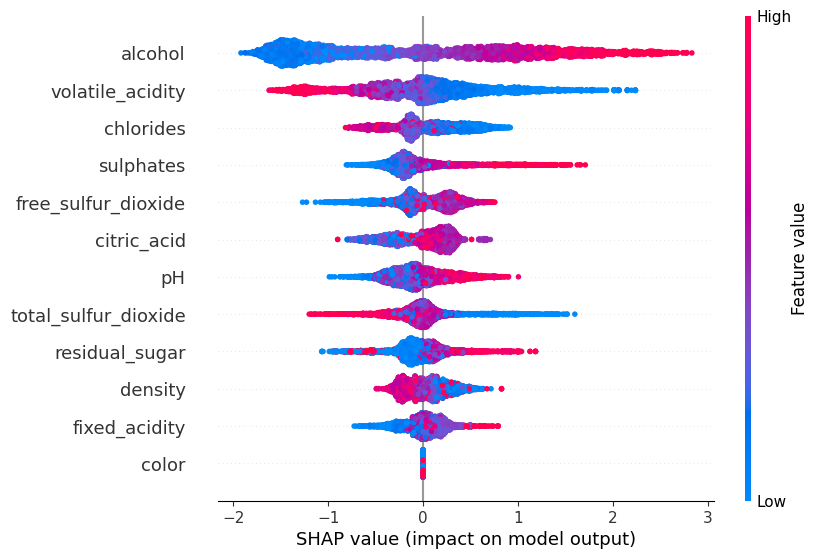

In [64]:
shap.plots.beeswarm(shap_values=shap_values,max_display=20)

Here we have once again the feature importance in a beeswarm plot.

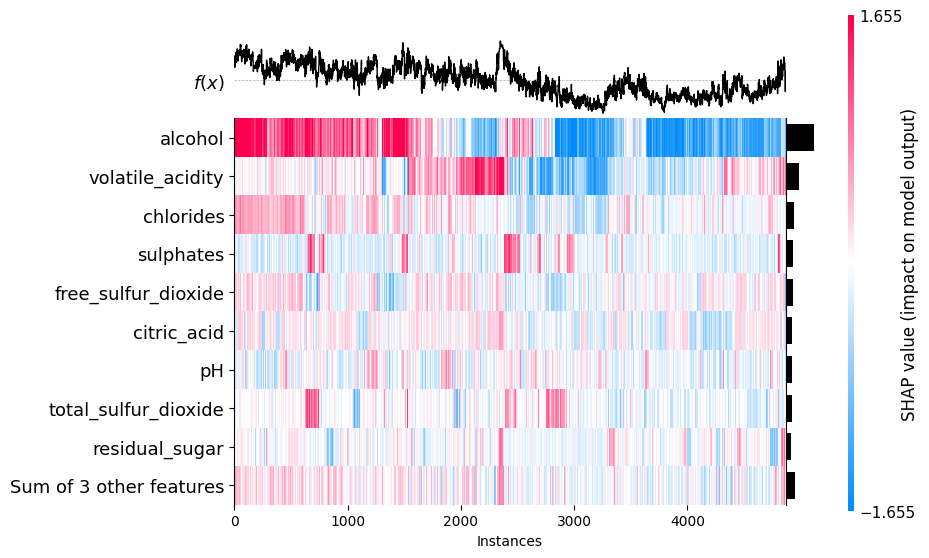

<Axes: xlabel='Instances'>

In [65]:
shap.plots.heatmap(shap_values)

Here, we can see the importance of each feature for every datapoint in the set.

We will use the partial dependance plot to examine the effect of three of the biggest factors to wine quality, volatile and fixed acidity as well as cictric acid.

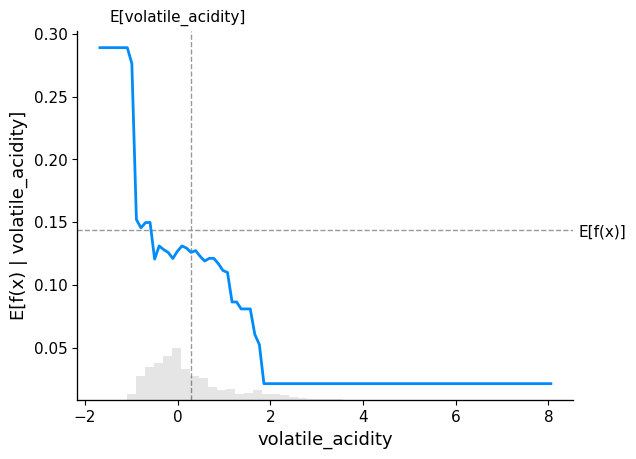

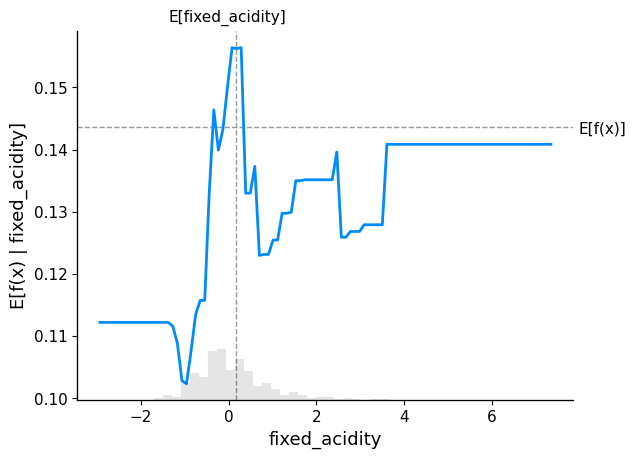

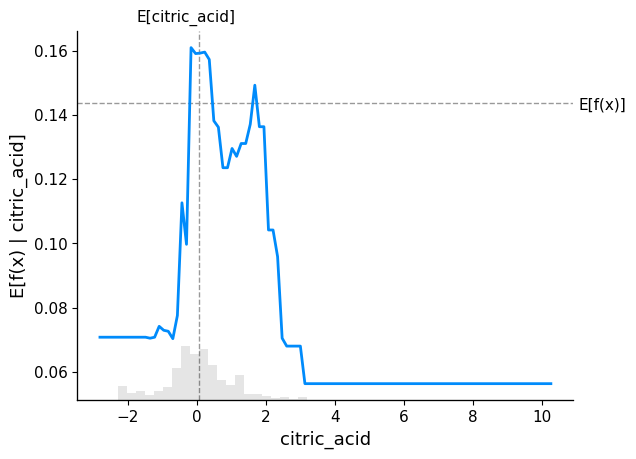

In [66]:
shap.partial_dependence_plot(
    "volatile_acidity",
    grid_search_3.best_estimator_.predict,
    X_qual_encoded,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
)
shap.partial_dependence_plot(
    "fixed_acidity",
    grid_search_3.best_estimator_.predict,
    X_qual_encoded,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
)

shap.partial_dependence_plot(
    "citric_acid",
    grid_search_3.best_estimator_.predict,
    X_qual_encoded,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
)
plt.show()

We can see here the impact of the different values of acidity in a wine.

### Analyze a few bad wines, and try to see how to make them better


We will now separete the best and worst wines to see if clear differences appear. We use a minmax scaler to set the value of all features between 0 and 1.

In [67]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler=MinMaxScaler()
minmax_X=pd.DataFrame(minmax_scaler.fit_transform(X.drop("color",axis=1)),columns=list(X)[:-1]).join(X["color"])

In [68]:
very_bad_wine=minmax_X[X.join(y)["quality"]==3]
very_bad_wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color
459,0.644628,0.333333,0.397590,0.024540,0.107973,0.031250,0.094470,0.263929,0.410853,0.196629,0.144928,red
517,0.545455,0.353333,0.295181,0.023006,0.317276,0.013889,0.023041,0.236939,0.341085,0.230337,0.057971,red
690,0.297521,0.736667,0.000000,0.055982,0.146179,0.013889,0.018433,0.182957,0.705426,0.179775,0.391304,red
832,0.545455,0.240000,0.253012,0.013804,0.225914,0.114583,0.096774,0.216117,0.511628,0.359551,0.275362,red
899,0.371901,0.626667,0.012048,0.042945,0.124585,0.017361,0.011521,0.227685,0.589147,0.151685,0.434783,red


The worst wines have a score of 3.

In [69]:
very_good_wine=minmax_X[X.join(y)["quality"]==9]
very_good_wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color
2373,0.438017,0.126667,0.271084,0.153374,0.043189,0.093750,0.271889,0.190669,0.372093,0.134831,0.347826,white
2419,0.231405,0.186667,0.174699,0.015337,0.019934,0.079861,0.182028,0.048969,0.534884,0.219101,0.637681,white
2426,0.297521,0.106667,0.216867,0.021472,0.036545,0.090278,0.306452,0.066320,0.434109,0.146067,0.652174,white
2475,0.256198,0.186667,0.204819,0.055215,0.014950,0.194444,0.260369,0.051860,0.434109,0.078652,0.681159,white
3204,0.272727,0.120000,0.295181,0.024540,0.038206,0.104167,0.246544,0.061500,0.503876,0.112360,0.710145,white


The best wines have a score of 9, but there is only 5 and no red, as such we will take the wine with a score of 8 instead.

In [70]:
very_good_wine=minmax_X[X.join(y)["quality"]==8]
very_good_wine["color"].describe()

count       193
unique        2
top       white
freq        175
Name: color, dtype: object

In [71]:
best_white_wine=very_good_wine[very_good_wine["color"]=="white"].drop("color",axis=1)
best_red_wine=very_good_wine[very_good_wine["color"]=="red"].drop("color",axis=1)

worst_white_wine=very_bad_wine[very_bad_wine["color"]=="white"].drop("color",axis=1)
worst_red_wine=very_bad_wine[very_bad_wine["color"]=="red"].drop("color",axis=1)

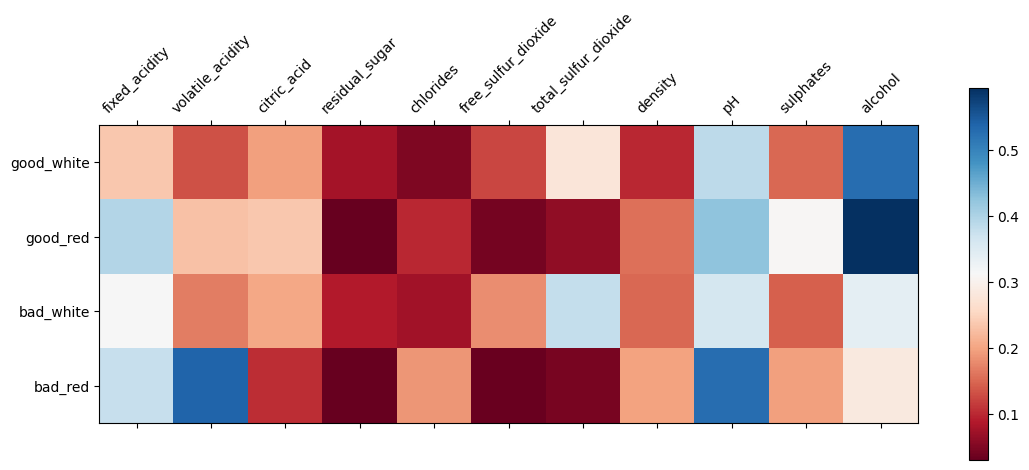

In [72]:



"""
best_worst_df=pd.DataFrame({
                            "good_white":pd.DataFrame(minmax_scaler.fit_transform(best_white_wine),columns=list(best_white_wine)).mean(),
                            "good_red":pd.DataFrame(minmax_scaler.fit_transform(best_red_wine),columns=list(best_white_wine)).mean(),
                            "bad_white":pd.DataFrame(minmax_scaler.fit_transform(worst_white_wine),columns=list(best_white_wine)).mean(),
                            "bad_red":pd.DataFrame(minmax_scaler.fit_transform(worst_red_wine),columns=list(best_white_wine)).mean()
                            })"""

best_worst_df=pd.DataFrame({
                            "good_white":best_white_wine.mean(),
                            "good_red":best_red_wine.mean(),
                            "bad_white":worst_white_wine.mean(),
                            "bad_red":worst_red_wine.mean()
                            })
plt.matshow(best_worst_df.transpose(),cmap="RdBu")
plt.xticks(labels=list(best_white_wine),ticks=range(0,11),rotation=45)
plt.yticks(labels=["good_white","good_red","bad_white","bad_red"],ticks=[0,1,2,3])
plt.colorbar()
plt.show()



Here we can see the mean values of each feature for the good/bad red/white wine. We can see for exemple the importance of alcohol content in good wine amongst other things.

# Wrap-up and conclusion

We have observed that it is possible to segragate the color (white/red) of wine based on chemical properties. Furthermore, it is also possible to determine the quality of a wine even in a mix set of data, altough the results would be better should the colors be separeted, as chemical characteristics varies  fairly strongly depending on it.

For white wine, a higher alcool content, lower density and lower sulfur dioxide concentration seems to indicate a better wine.

Red wine also benefits from higher alcohol content as well as lower volatile acidity and higher citric acid content.

Of course, the sample of very good wine is fairly limited, but these recommendation should nonetheless be solid.

As the set only contains wine wich are drinkable, we also lack the true upper and lower bound for diminishing return, or even regression. For exemple, it is doubtfull a wine with 30% alcohol content would be considered good. As such, indicating lower or upper bounds is not possible.